In [1]:
import numpy as np
import pandas as pd
import sklearn
from IPython.display import Image
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Perceptron class

In [2]:
class Perceptron:
    
    def __init__(self,n):  
        '''
        Creates a single n dimensional input perceptron (without bias).
        Initializes weights W to random values, change-in-weights vector ΔW
        after backpropagation and error-gradient δ.
        '''        
        self.input_dim = n
        #by default we have random weights initialised to break symmetry
        self.weights = np.random.normal(scale=0.1, size=n)
        self.inputs_y = np.zeros(n)
        # ΔW : weight update calculated during backprop
        self.store_weight_updates = np.zeros(n)
        # δ : error-gradient for this Perceptron
        self.delta = 0
        
    def calculate_activation(self):  
        '''
        Calculates the sigmoid activation output of Perceptron.
        ''' 
        self.sum = np.dot(self.weights, self.inputs_y)
        self.output_y = 1/(1+np.exp(-self.sum))
        return self.output_y        
        
    def set_inputs(self, inpt):   
        '''
        Set input for a single datasample.
        '''
        self.inputs_y = np.asarray(inpt)
        
    def set_target(self, trgt):
        '''
        Set the corresponding label/target for the datasample whose input was set.
        ''' 
        self.target = trgt
        
    def getWeights(self):
        '''
        Returns the present weights (and bias) of the Perceptron.
        '''        
        return self.weights 
    
    def getInputs(self):
        '''
        get currently-set input.
        '''        
        return self.inputs_y 

    def store_delta(self,delta):
        '''
        stores the error-gradient δ for this Perceptron calculated 
        using backpropagation.
        '''        
        self.delta = delta
        
    def store_weight_updates_backprop(self, delweights):
        '''
        Accumulates the ΔW vector weights. We would want to accumulate the ΔW for weights
        when using BGD ie Batch Gradient Descent.
        '''
        self.store_weight_updates = self.store_weight_updates + delweights   
    
    def update_weights_backprop(self, batchsize):
        '''
        Updates all the weights for the perceptron using ΔW vector.
        '''
        self.weights = self.weights + self.store_weight_updates/batchsize
        self.store_weight_updates = np.zeros(self.input_dim)
        

# MLP Network class

In [3]:
class MLP:
    
    def __init__(self,n):  
        '''
        Initialize the MLP with n-inputs.
        '''
        self.inputs = np.zeros(n)
        self.network=[]
        self.last_layer_dim = n

    def add_layer(self,numOfPerceptron):
        '''
        add layer to MLP. A layer consists of [numOfPerceptron] Perceptron objects.
        '''
        layer=[]
        for i in range(numOfPerceptron):
            layer.append(Perceptron(self.last_layer_dim))
        self.network.append(layer)
        self.last_layer_dim = numOfPerceptron
        self.output_MLP = np.array(self.last_layer_dim)
        
    def getNetwork(self):
        '''
        returns the Network array consisiting of layers.
        '''
        return self.network
        
    def set_inputs(self, inpt):   
        '''
        Set single datasample as input.
        '''
        self.inputs = inpt       

    
    def feedforward(self):
        '''
        Feedforwards the input sample and updates the MLP output activation.
        '''
        input_data = self.inputs
        
        for layer in self.network:
            output = np.empty(0,dtype='float64')
            for perceptrn in layer:
                perceptrn.set_inputs(input_data)
                output = np.append(output,perceptrn.calculate_activation())
            input_data = output 
            
        self.output_MLP = input_data           #the possibly vector output of last perceptron(s)
    
    def getOutputMLP(self):
        '''
        returns the MLP output activation.
        '''
        return self.output_MLP
    
    def backpropagate(self, lr):        
        '''
        Stores the change-in-weights vector ΔW and error-gradient δ for each Perceptron
        in the MLP starting from the Output layer to all the hidden layers in reverse.
        '''
        error = self.target-self.getOutputMLP()        

        # prev_layer_weights_sum is used by the Hidden layers in the equation for δ
        prev_layer_weights_sum=[]    
        
        # for output layer:
        for j,perceptrn in enumerate(self.network[-1]):
            # y is the current output of the selected perceptron in the output layer.
            y=perceptrn.calculate_activation()
            # calculate the ΔW and δ for each perceptron.
            delta = -1*error[j]*y*(1-y)                                        #requires negative sign for output layer!!!
            delweights = -lr*delta*perceptrn.getInputs()
            # store the calculated ΔW and δ in the perceptron.
            perceptrn.store_weight_updates_backprop(delweights)
            perceptrn.store_delta(delta)
            # Store this layers weights*delta to be used by the preceeding layer.
            prev_layer_weights_sum.append(perceptrn.getWeights()*delta)            
        prev_layer_weights_sum = np.asarray(prev_layer_weights_sum)      
        
        #for all hidden layers going in reverse
        for layer in reversed(self.network[0:len(self.network)-1]):
            temp_prev_layer_sum = []
            for i,perceptrn in enumerate(layer):
                # y is the current output of the selected perceptron in the current layer.
                y=perceptrn.calculate_activation()
                # calculate the ΔW and δ for each perceptron.
                delta = y*(1-y)*prev_layer_weights_sum.sum(axis=0)[i]          #no negative sign in hidden layers!!!
                delweights = -lr*delta*perceptrn.getInputs()    
                # store the calculated ΔW and δ in the perceptron.
                perceptrn.store_weight_updates_backprop(delweights)
                perceptrn.store_delta(delta)
                # Store this layers weights*delta to be used by the preceeding layer.
                temp_prev_layer_sum.append(perceptrn.getWeights()*delta)
            prev_layer_weights_sum = np.asarray(temp_prev_layer_sum)
              
    
    def update_Network_Weights(self, batchsize):
        '''
        Triggers the updation of weights using the ΔW already stored in all perceptrons in MLP.
        '''
        for layer in self.network:
            for perceptrn in layer:
                perceptrn.update_weights_backprop(batchsize)
                
    def update_MSE_error(self, target):
        '''
        Sets the target for current datasample input. 
        Updates the MSE error too (but only for the single datasample not for the
        whole dataset).
        '''
        self.target = np.asarray(target)
        self.MSE = np.square(self.target-self.getOutputMLP()).mean()/2      
   
    def getMSE(self):
        '''
        return the MSE for the just-seen input by the MLP.
        '''
        return self.MSE
            
    def testMLP(self, testdata):
        '''
        Tests the MLP on the [testdata] dataset and return the 
        predicted values vector.
        '''
        result = []
        for i in testdata:
            self.set_inputs(i)
            self.feedforward()
            res_i = self.getOutputMLP()
            res_i[res_i>=0.5] = 1
            res_i[res_i<0.5] = 0
            result.append(res_i)            
        return np.asarray(result)
    
    def printNetwork(self):
        '''
        Prints the Network
        '''
        print("****************NETWORK***************")
        print("Layer 0")
        print("----input dimension",len(self.inputs))
        k=1
        for i in self.network:
            print("Layer",k)
            k+=1
            for j in i:
                print("----",j)

# a) Testing on custom dataset using SGD

#### Dataset

In [4]:
#gives 20 feature binary dataset of 1000 samples
x,y = make_classification(n_samples=1000)
print(x.shape)
print(y.shape)

(1000, 20)
(1000,)


#### Test-Train Split

In [5]:
data_train, data_test, target_train, target_test = train_test_split(x,y,test_size = 0.2 ,random_state = 42)

#### Making the MLP network

In [6]:
M=MLP(20)
M.add_layer(10)
M.add_layer(5)
M.add_layer(1)
M.printNetwork()

****************NETWORK***************
Layer 0
----input dimension 20
Layer 1
---- <__main__.Perceptron object at 0x0000028BB680E940>
---- <__main__.Perceptron object at 0x0000028BB680E0B8>
---- <__main__.Perceptron object at 0x0000028BB680E0F0>
---- <__main__.Perceptron object at 0x0000028BB680E4E0>
---- <__main__.Perceptron object at 0x0000028BB680E9B0>
---- <__main__.Perceptron object at 0x0000028BB680E978>
---- <__main__.Perceptron object at 0x0000028BB680EAC8>
---- <__main__.Perceptron object at 0x0000028BB680EB38>
---- <__main__.Perceptron object at 0x0000028BB680EB70>
---- <__main__.Perceptron object at 0x0000028BB680EA20>
Layer 2
---- <__main__.Perceptron object at 0x0000028BB680E358>
---- <__main__.Perceptron object at 0x0000028BB680EB00>
---- <__main__.Perceptron object at 0x0000028BB680EBA8>
---- <__main__.Perceptron object at 0x0000028BB680EC88>
---- <__main__.Perceptron object at 0x0000028BB680ECC0>
Layer 3
---- <__main__.Perceptron object at 0x0000028BB620AB00>


#### Train MLP

In [7]:
for t in range(1,21):
    print("epoch",t)
    for i,j in zip(data_train,target_train):
        M.set_inputs(i)
        M.feedforward()
        M.update_MSE_error(target=[j])          #target must be sequence of 0 or 1 as sigmoid was used in output of MLP.        
        M.backpropagate(lr=0.1)
        # update the network weights immediately after each train sample is seen by MLP.
        M.update_Network_Weights(1)
      
    # prints train accuracy after each epoch
    res = M.testMLP(data_train)
    print("train accuracy: ",accuracy_score(res,target_train))

epoch 1
train accuracy:  0.49875
epoch 2
train accuracy:  0.49875
epoch 3
train accuracy:  0.61
epoch 4
train accuracy:  0.8175
epoch 5
train accuracy:  0.8725
epoch 6
train accuracy:  0.9025
epoch 7
train accuracy:  0.905
epoch 8
train accuracy:  0.91125
epoch 9
train accuracy:  0.91375
epoch 10
train accuracy:  0.91375
epoch 11
train accuracy:  0.915
epoch 12
train accuracy:  0.915
epoch 13
train accuracy:  0.915
epoch 14
train accuracy:  0.91625
epoch 15
train accuracy:  0.91625
epoch 16
train accuracy:  0.91625
epoch 17
train accuracy:  0.91625
epoch 18
train accuracy:  0.91625
epoch 19
train accuracy:  0.91625
epoch 20
train accuracy:  0.9175


#### Test MLP

In [8]:
res = M.testMLP(data_test)
print("test accuracy: ",accuracy_score(res,target_test))

test accuracy:  0.885


#### Preicted values

In [9]:
res

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],

#### Get Network Weights

In [10]:
NN = M.getNetwork()
for layer in NN:
    for perceptrn in layer:
        print(perceptrn.getWeights())

[-0.01395146 -0.01710935  0.22390993 -0.123849    0.2069627   0.12064936
  0.26540371 -0.1947961  -0.01241745 -0.01890398  0.12926539  0.2303751
  1.01589426  0.02779663 -0.21950549 -0.0963472   0.1092272  -0.23126679
 -0.67071498 -0.08747345]
[-0.12459809  0.00526704 -0.16582957  0.19390314 -0.1848314   0.02131757
 -0.22752177  0.17955724 -0.01523821 -0.04982455 -0.0691067  -0.24094449
 -0.97243095  0.00359104  0.1932161   0.05422043 -0.15370128  0.1144177
  0.82919172  0.09725959]
[-0.03345297 -0.02769282 -0.15184811 -0.07540176 -0.08941141  0.17373903
 -0.0720875  -0.09230236 -0.05896156  0.1586676  -0.28147712 -0.27415182
 -0.59559381 -0.01924602  0.14070683  0.02145456  0.00509049  0.0912476
  0.44057952  0.07509971]
[-0.0743415  -0.0291429   0.17792395 -0.07981229  0.08325541  0.07590898
  0.06181893 -0.00702519 -0.27364914  0.02155699  0.06688286  0.3646217
  0.24154142  0.09971354 -0.08860768 -0.0629576  -0.0219578  -0.0054259
 -0.20230768 -0.08599716]
[ 0.10888929  0.13708055 

# b) Verifying Slide Example

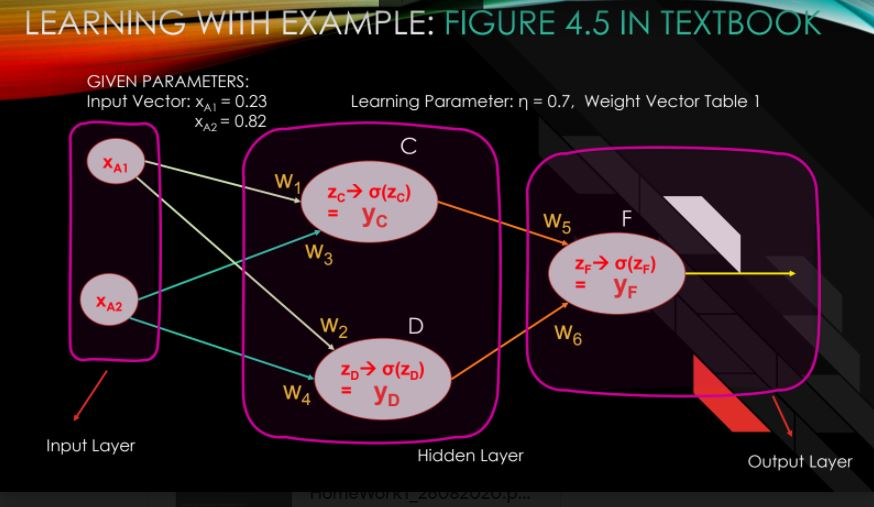

In [11]:
Image(filename='img1.jpg')
# Source : 
# Slide #6 from BITS F312 (Lecture on Aug 30, 2020) from presentation titled
# 'TRAINING BY BACKPROPAGATION OF THE ERROR: WORKING ON AN EXAMPLE NETWORK'

#### Making the MLP network

In [12]:
M=MLP(2)
M.add_layer(2)
M.add_layer(1)
M.printNetwork()

****************NETWORK***************
Layer 0
----input dimension 2
Layer 1
---- <__main__.Perceptron object at 0x0000028BB516BBE0>
---- <__main__.Perceptron object at 0x0000028BB285F278>
Layer 2
---- <__main__.Perceptron object at 0x0000028BB285F208>


#### Initializing values as given in table

In [15]:
NN = M.getNetwork()
NN[0][0].weights = np.asarray([0.1, 0.4])
NN[0][1].weights = np.asarray([0.5, 0.3])
NN[1][0].weights = np.asarray([0.2, 0.6])
M.set_inputs([0.23,0.82])

#### Run for some iterations 

In [16]:
for i in range(4):
    print("ITERATION ---- ",i)
    M.feedforward()
    print("df:",NN[1][0].delta)
    print("dc:",NN[0][0].delta)
    print("dd:",NN[0][1].delta)
    print("[W1 W3]:",NN[0][0].weights)
    print("[W2 W4]:",NN[0][1].weights)
    print("[W5 W6]:",NN[1][0].weights)
    print("Yc:",NN[0][0].calculate_activation())
    print("Yd:",NN[0][1].calculate_activation())
    print("Yf:",NN[1][0].calculate_activation())
    M.update_MSE_error(target=[1])                  # target must be sequence of 0 or 1 as sigmoid was used in output of MLP.
    print("Epsilon:",M.getMSE())
    M.backpropagate(0.7)
    M.update_Network_Weights(1)
    print()

ITERATION ----  0
df: -0.08088790109295463
dc: -0.006031620644053865
dd: -0.013820303741523765
[W1 W3]: [0.1 0.4]
[W2 W4]: [0.5 0.3]
[W5 W6]: [0.2 0.6]
Yc: 0.58686005528943
Yd: 0.5892824842873394
Yf: 0.6156065729784533
Epsilon: 0.07387915336868456

ITERATION ----  1
df: -0.09096098483969092
dc: -0.00441079513375138
dd: -0.013209097963105099
[W1 W3]: [0.10071014 0.4025318 ]
[W2 W4]: [0.50212666 0.30758202]
[W5 W6]: [0.23736696 0.6375212 ]
Yc: 0.5874029051011583
Yd: 0.5909046456272363
Yf: 0.6262457288764469
Epsilon: 0.0698461275915492

ITERATION ----  2
df: -0.0874816781655341
dc: -0.005032683575858252
dd: -0.013481980334919163
[W1 W3]: [0.1015204  0.40542056]
[W2 W4]: [0.50429726 0.31532068]
[W5 W6]: [0.27333785 0.67370653]
Yc: 0.5880220330132746
Yd: 0.5925582800891895
Yf: 0.6364384405851877
Epsilon: 0.06608850374206504

ITERATION ----  3
df: -0.08412252852441643
dc: -0.005570314103897698
dd: -0.013682946959982739
[W1 W3]: [0.10241722 0.40861792]
[W2 W4]: [0.50650022 0.32317469]
[W5 W6]

# c) BGD vs SGD

We use the same dataset and same MLP specification used for custom dataset training using SGD

In [18]:
M=MLP(20)
M.add_layer(10)
M.add_layer(5)
M.add_layer(1)
M.printNetwork()

****************NETWORK***************
Layer 0
----input dimension 20
Layer 1
---- <__main__.Perceptron object at 0x0000028BB680EAC8>
---- <__main__.Perceptron object at 0x0000028BB680EF28>
---- <__main__.Perceptron object at 0x0000028BB680ED30>
---- <__main__.Perceptron object at 0x0000028BB680ED68>
---- <__main__.Perceptron object at 0x0000028BB680E320>
---- <__main__.Perceptron object at 0x0000028BB680E080>
---- <__main__.Perceptron object at 0x0000028BB680E048>
---- <__main__.Perceptron object at 0x0000028BB680E710>
---- <__main__.Perceptron object at 0x0000028BB680E748>
---- <__main__.Perceptron object at 0x0000028BB680E0B8>
Layer 2
---- <__main__.Perceptron object at 0x0000028BB680E828>
---- <__main__.Perceptron object at 0x0000028BB680E668>
---- <__main__.Perceptron object at 0x0000028BB680E518>
---- <__main__.Perceptron object at 0x0000028BB680E0F0>
---- <__main__.Perceptron object at 0x0000028BB680E438>
Layer 3
---- <__main__.Perceptron object at 0x0000028BB680E940>


#### Train MLP (BGD)

In [19]:
for t in range(1,21):
    print("epoch",t)
    counter = 0
    for i,j in zip(data_train,target_train):
        M.set_inputs(i)
        M.feedforward()
        M.update_MSE_error(target=np.asarray([j]))  #target must be sequence of 0 or 1 as sigmoid was used in output of MLP.       
        M.backpropagate(lr=0.1)
        counter+=1
        
    #update the weights after the whole dataset is seen by MLP
    M.update_Network_Weights(len(target_train))
      
    #train accuracy after each epoch 
    res = M.testMLP(data_train)
    print("train accuracy: ",accuracy_score(res,target_train))

epoch 1
train accuracy:  0.50125
epoch 2
train accuracy:  0.50125
epoch 3
train accuracy:  0.50125
epoch 4
train accuracy:  0.50125
epoch 5
train accuracy:  0.50125
epoch 6
train accuracy:  0.50125
epoch 7
train accuracy:  0.50125
epoch 8
train accuracy:  0.50125
epoch 9
train accuracy:  0.50125
epoch 10
train accuracy:  0.50125
epoch 11
train accuracy:  0.50125
epoch 12
train accuracy:  0.50125
epoch 13
train accuracy:  0.50125
epoch 14
train accuracy:  0.50125
epoch 15
train accuracy:  0.50125
epoch 16
train accuracy:  0.50125
epoch 17
train accuracy:  0.50125
epoch 18
train accuracy:  0.50125
epoch 19
train accuracy:  0.50125
epoch 20
train accuracy:  0.50125


We need to adjust batch size and/or lr for network to learn.

#### Test MLP (BGD)

In [20]:
res = M.testMLP(data_test)
print("test accuracy: ",accuracy_score(res,target_test))

test accuracy:  0.5


# Multi dimensional output label with SGD (Optional)

In [42]:
n_dim = 4
#gives 20 feature with n_dim output dataset of 1000 samples
x,y = make_classification(n_samples=1000, n_classes=n_dim, n_informative=8)

In [43]:
print(x.shape)
print(y.shape)

(1000, 20)
(1000,)


In [44]:
#print some label samples from y
print(y[0:10])

[1 3 0 1 0 0 2 1 3 3]


In [45]:
#ONE HOT ENCODE
y= np.squeeze(np.eye(n_dim)[y.reshape(-1)])
print(y)

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [46]:
data_train, data_test, target_train, target_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [47]:
M=MLP(20)
M.add_layer(10)
#do not make deep Nets
M.add_layer(10)
# has n_dim as ouput number of perceptrons
M.add_layer(4)
M.printNetwork()

****************NETWORK***************
Layer 0
----input dimension 20
Layer 1
---- <__main__.Perceptron object at 0x0000028BB6736E48>
---- <__main__.Perceptron object at 0x0000028BB5D72438>
---- <__main__.Perceptron object at 0x0000028BB5D72518>
---- <__main__.Perceptron object at 0x0000028BB5D7DF98>
---- <__main__.Perceptron object at 0x0000028BB5D852E8>
---- <__main__.Perceptron object at 0x0000028BB67FAD68>
---- <__main__.Perceptron object at 0x0000028BB67FAB00>
---- <__main__.Perceptron object at 0x0000028BB67FAAC8>
---- <__main__.Perceptron object at 0x0000028BB67FA898>
---- <__main__.Perceptron object at 0x0000028BB67FAC88>
Layer 2
---- <__main__.Perceptron object at 0x0000028BB58E0BA8>
---- <__main__.Perceptron object at 0x0000028BB67FA908>
---- <__main__.Perceptron object at 0x0000028BB67FADA0>
---- <__main__.Perceptron object at 0x0000028BB67FAFD0>
---- <__main__.Perceptron object at 0x0000028BB67FAEB8>
---- <__main__.Perceptron object at 0x0000028BB58E36D8>
---- <__main__.Per

In [48]:
for t in range(1,51):
    print("epoch",t)
    for i,j in zip(data_train,target_train):
        M.set_inputs(i)
        M.feedforward()
        M.update_MSE_error(target=j)          #target must be sequence of 0 or 1 as sigmoid was used in output of MLP.       
        M.backpropagate(lr=0.1)
        M.update_Network_Weights(1)
      
    #train accuracy after each epoch
    res = M.testMLP(data_train)
    print("train accuracy: ",accuracy_score(res,target_train))

epoch 1
train accuracy:  0.0
epoch 2
train accuracy:  0.0
epoch 3
train accuracy:  0.0
epoch 4
train accuracy:  0.0
epoch 5
train accuracy:  0.0
epoch 6
train accuracy:  0.0
epoch 7
train accuracy:  0.0025
epoch 8
train accuracy:  0.02
epoch 9
train accuracy:  0.03875
epoch 10
train accuracy:  0.065
epoch 11
train accuracy:  0.12
epoch 12
train accuracy:  0.21625
epoch 13
train accuracy:  0.3425
epoch 14
train accuracy:  0.39
epoch 15
train accuracy:  0.41875
epoch 16
train accuracy:  0.44375
epoch 17
train accuracy:  0.46
epoch 18
train accuracy:  0.46625
epoch 19
train accuracy:  0.47375
epoch 20
train accuracy:  0.48125
epoch 21
train accuracy:  0.49375
epoch 22
train accuracy:  0.51625
epoch 23
train accuracy:  0.53
epoch 24
train accuracy:  0.54125
epoch 25
train accuracy:  0.55875
epoch 26
train accuracy:  0.57375
epoch 27
train accuracy:  0.585
epoch 28
train accuracy:  0.6025
epoch 29
train accuracy:  0.61
epoch 30
train accuracy:  0.61875
epoch 31
train accuracy:  0.63125
epoc

In [49]:
res = M.testMLP(data_test)
print("test accuracy: ",accuracy_score(res,target_test))

test accuracy:  0.6


In [50]:
res

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
